### Imports and Environment

In [35]:
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO

In [247]:
import torch as th
import pandas as pd
import gymnasium as gym
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO

import numpy as np

import collections
import gymnasium as gym
import numpy as np
import os

import tqdm

from matplotlib import pyplot as plt
from typing import Any, List, Sequence, Tuple

import pickle

import path_datatype
import sys

from env import tradingEng

# Define environment
file_path = os.path.abspath("../MarketGeneratingFunctions/1corr100pathsHWRunDemo.pkl")
with open(file_path,"rb") as fp:
    paths = pickle.load(fp)
env = tradingEng(paths)

/Users/isabellebyman/opt/anaconda3/envs/exjobb/lib/python3.13/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [246]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
import importlib
import env
importlib.reload(env) 
# env = env.tradingEng(paths)

<module 'env' from '/Users/isabellebyman/Documents/Courses_LTH/Exjobb/cva_risk_management_thesis/Hedge/env.py'>

# DDPG

In [150]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True, skip_render_check=True)

AssertionError: The observation returned by the `reset()` method does not match the data type (cannot cast) of the given observation space Box([  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. -inf], [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 inf inf inf inf inf inf inf inf inf  1.  1.  1.  1.  1.  1.  1.  1.  1.
 inf], (37,), float32). Expected: float32, actual dtype: float64

### Making the Agent

In [125]:
n_actions = 18
action_noise = OrnsteinUhlenbeckActionNoise(mean = np.zeros(n_actions), sigma = 0.001*np.ones(n_actions), theta = 0.001)
model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1, batch_size=25)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Training the Agent

In [126]:
Nruns = 10
model.learn(total_timesteps=252*10*Nruns, log_interval=2)
model.save("ddpg_fin")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.17e+03 |
|    ep_rew_mean     | -0.0116  |
| time/              |          |
|    episodes        | 2        |
|    fps             | 234      |
|    time_elapsed    | 10       |
|    total_timesteps | 2344     |
| train/             |          |
|    actor_loss      | -0.397   |
|    critic_loss     | 0.000196 |
|    learning_rate   | 0.001    |
|    n_updates       | 1172     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.17e+03 |
|    ep_rew_mean     | -0.0144  |
| time/              |          |
|    episodes        | 4        |
|    fps             | 162      |
|    time_elapsed    | 28       |
|    total_timesteps | 4688     |
| train/             |          |
|    actor_loss      | -0.573   |
|    critic_loss     | 0.000226 |
|    learning_rate   | 0.001    |
|    n_updates       | 3516     |
--------------

### Run a test

In [127]:
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
num_eval_episodes = 1

episode_over = False
rewards = list()
actions = list()
pnl = list()
obs, info = env.reset()
while not episode_over:
    action, _states = model.predict(obs, deterministic=True)  # replace with actual agent
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    pnl.append(info['P&L'])
    episode_over = terminated or truncated
env.close()

print(f'Example action taken: {actions}')
print(f'Episode rewards: {rewards}')

Example action taken: [array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1

In [51]:
num_eval_episodes = 10

rewards_tot = list()
actions_tot = list()
pnl_tot = list()
obs, info = env.reset()
for i in range(num_eval_episodes):
    episode_over = False
    rewards = list()
    actions = list()
    pnl = list()
    obs, info = env.reset()
    while not episode_over:
        action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        actions.append(action)
        pnl.append(info['P&L'])
        episode_over = terminated or truncated
    env.close()
    rewards_tot.append(rewards)
    actions_tot.append(actions)
    pnl_tot.append(pnl)

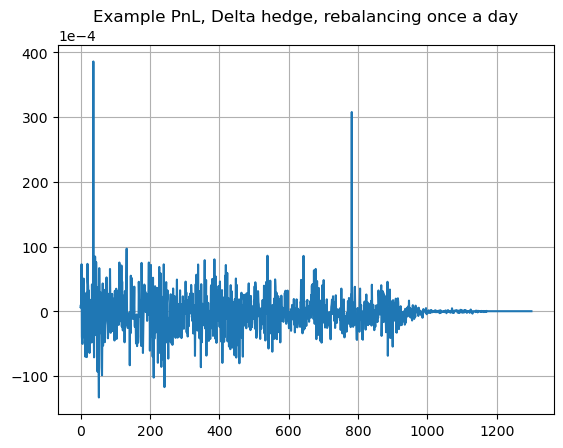

In [55]:
plt.figure(1)
plt.title("Example PnL, Delta hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(pnl_tot[1])

In [53]:
np.percentile(pnl_tot[9], 5)

np.float64(-0.004446889275215954)

In [54]:
np.percentile(pnl_tot[1], 5)

np.float64(-0.004446889275215954)

# PPO

In [230]:
env = env.tradingEng(paths)


In [248]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO

# Create and normalize the environment
env = DummyVecEnv([lambda: tradingEng(paths)])
env = VecNormalize(env, norm_obs=True, norm_reward=True)

# Train PPO model
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi=[512,512], vf=[512,512]))
model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs,  verbose=1, batch_size=2048, n_steps=512, gamma=0.99, learning_rate=5e-3, clip_range=1.0, ent_coef=0.01, gae_lambda=1.0, vf_coef=0.5)
model.learn(total_timesteps=252*Nruns, log_interval=2)

# Save model and normalization stats
model.save("ppo_trading")
env.save("vec_normalize.pkl")

# Reload model and environment
env = DummyVecEnv([lambda: tradingEng(paths)])
env = VecNormalize.load("vec_normalize.pkl", env)
model = PPO.load("ppo_trading", env=env)


Using cpu device


/Users/isabellebyman/opt/anaconda3/envs/exjobb/lib/python3.13/site-packages/stable_baselines3/ppo/ppo.py:148: UserWarning: You have specified a mini-batch size of 2048, but because the `RolloutBuffer` is of size `n_steps * n_envs = 512`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 512
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=512 and n_envs=1)
  warnings.warn(


----------------------------------------
| time/                   |            |
|    fps                  | 888        |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 1024       |
| train/                  |            |
|    approx_kl            | 5.1067424  |
|    clip_fraction        | 0.154      |
|    clip_range           | 1          |
|    entropy_loss         | -25.5      |
|    explained_variance   | -4.8629594 |
|    learning_rate        | 0.005      |
|    loss                 | -0.908     |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.378     |
|    std                  | 0.994      |
|    value_loss           | 5.7        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 772         |
|    iterations           | 4           |
|    time_elapsed         | 2           |
|    total_

/Users/isabellebyman/opt/anaconda3/envs/exjobb/lib/python3.13/site-packages/stable_baselines3/common/save_util.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_objec

In [255]:
num_eval_episodes = 10

rewards_tot = list()
actions_tot = list()
pnl_tot = list()
obs = env.reset()
for i in range(num_eval_episodes):
    episode_over = False
    rewards = list()
    actions = list()
    pnl = list()
    obs = env.reset()
    while not episode_over:
        action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
        obs, reward, terminated, truncated = env.step(action)
        rewards.append(reward)
        actions.append(action)
        pnl.append(info['P&L'])
        episode_over = terminated or truncated
    # env.close()
    rewards_tot.append(rewards)
    actions_tot.append(actions)
    pnl_tot.append(pnl)

In [256]:
pnl_tot[0]

[np.float64(-1.048909976172067e-12)]

In [181]:
from stable_baselines3.common.monitor import Monitor
import os

log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir + "monitor.csv")  # Properly wrapped

In [208]:

log_dir = "./logs/"  # Define a log directory
os.makedirs(log_dir, exist_ok=True)  # Create it if it doesn't exist

env = Monitor(env, log_dir + "monitor.csv")  # Save log file

# env = DummyVecEnv([lambda: Monitor(env, log_dir + "monitor.csv")])  # ✅ Correct
# env = VecNormalize(env, norm_reward=True)
# tensorboard_log = "./ppo_tensorboard/"

In [209]:

policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi=[512,512], vf=[512,512]))
model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs,  verbose=1, batch_size=2048, n_steps=512, gamma=0.99, learning_rate=5e-3, clip_range=1.0, ent_coef=0.01, gae_lambda=1.0, vf_coef=0.5) #ent_coef: add randomness (0), clip_range: policy updates, gae_lambda: lower-->more exploration

Using cpu device
Wrapping the env in a DummyVecEnv.


### Training the Agent

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 2.27e+03       |
|    ep_rew_mean          | -1.54e+04      |
| time/                   |                |
|    fps                  | 738            |
|    iterations           | 2              |
|    time_elapsed         | 5              |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | 0.018740967    |
|    clip_fraction        | 0.0446         |
|    clip_range           | 0.3            |
|    entropy_loss         | -25.6          |
|    explained_variance   | -4.4941902e-05 |
|    learning_rate        | 3e-05          |
|    loss                 | 6.49           |
|    n_updates            | 10             |
|    policy_gradient_loss | -0.0123        |
|    std                  | 1.01           |
|    value_loss           | 1.5e+04        |
--------------------------------------------
----------

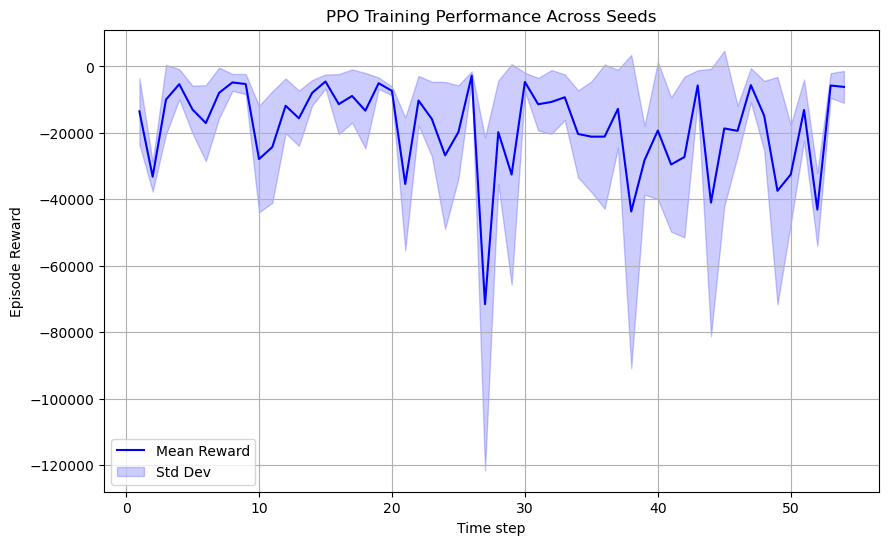

In [168]:
Nruns = 500  # Define how many runs per seed

all_rewards = []  #c Store rewards for each seed

for i in range(3):
    model.learn(total_timesteps=252 * Nruns, log_interval=2)

    # Load monitor data for this seed
    log_data = pd.read_csv(log_dir + "monitor.csv", skiprows=1)
    
    # Store rewards
    all_rewards.append(log_data["r"].values)  # Ensure rewards are saved in a list
    
    env = Monitor(env, log_dir + "monitor.csv")  # Save log file
# Convert to numpy array for easier manipulation
all_rewards = np.array(all_rewards)

# Compute mean and standard deviation across seeds
mean_rewards = np.mean(all_rewards, axis=0)
std_rewards = np.std(all_rewards, axis=0)

# Time steps (assuming sequential logging)
time_steps = np.arange(len(mean_rewards))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_steps, mean_rewards, label="Mean Reward", color="blue")
plt.fill_between(time_steps, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2, color="blue", label="Std Dev")

plt.xlabel("Time step")
plt.ylabel("Episode Reward")
plt.title("PPO Training Performance Across Seeds")
plt.legend()
plt.grid()
plt.show()


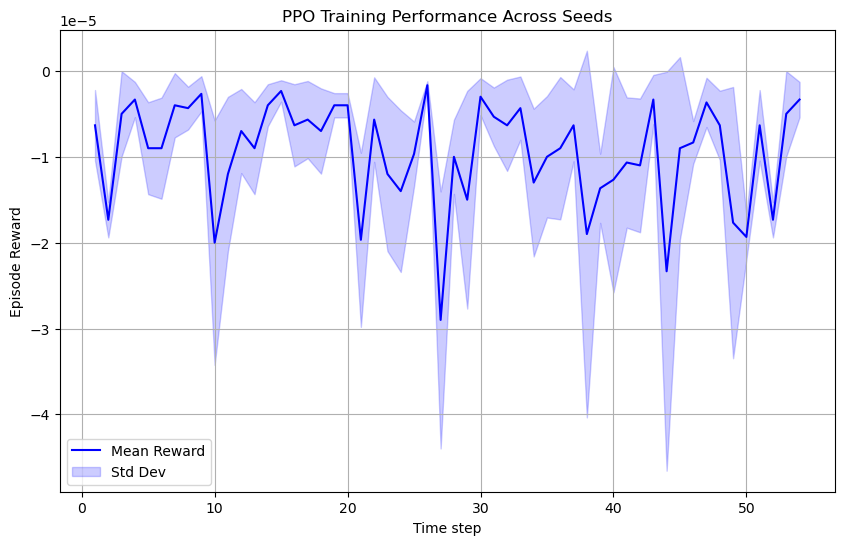

In [153]:
all_rewards = np.array(all_rewards)

# Compute mean and standard deviation across seeds
mean_rewards = np.mean(all_rewards, axis=0)
std_rewards = np.std(all_rewards, axis=0)

# Time steps (assuming sequential logging)
time_steps = np.arange(len(mean_rewards[:-1]))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_steps, mean_rewards[:-1], label="Mean Reward", color="blue")
plt.fill_between(time_steps, mean_rewards[:-1] - std_rewards[:-1], mean_rewards[:-1] + std_rewards[:-1], alpha=0.2, color="blue", label="Std Dev")

plt.xlabel("Time step")
plt.ylabel("Episode Reward")
plt.title("PPO Training Performance Across Seeds")
plt.legend()
plt.grid()
plt.show()

In [189]:
Nruns = 500
model.learn(total_timesteps=252*Nruns, log_interval=2) # exploration_fraction=0.2 Runs in total total_timesteps. After every n_steps, update the policy. Makes decision based on batch_size.
model.save("ppo_fin")

----------------------------------------
| time/                   |            |
|    fps                  | 940        |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 1024       |
| train/                  |            |
|    approx_kl            | 0.27279052 |
|    clip_fraction        | 0.0865     |
|    clip_range           | 1          |
|    entropy_loss         | -25.5      |
|    explained_variance   | 0.16625553 |
|    learning_rate        | 0.005      |
|    loss                 | -0.382     |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0915    |
|    std                  | 0.996      |
|    value_loss           | 0.283      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 825         |
|    iterations           | 4           |
|    time_elapsed         | 2           |
|    total_

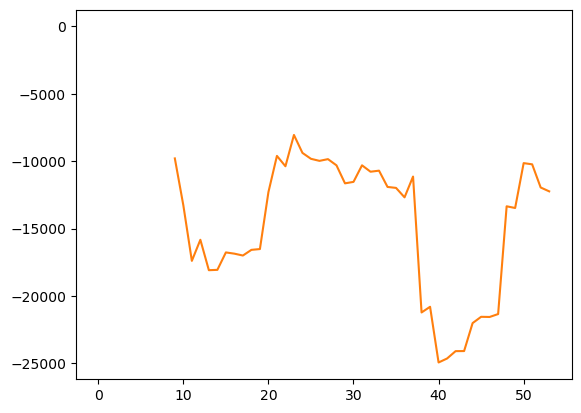

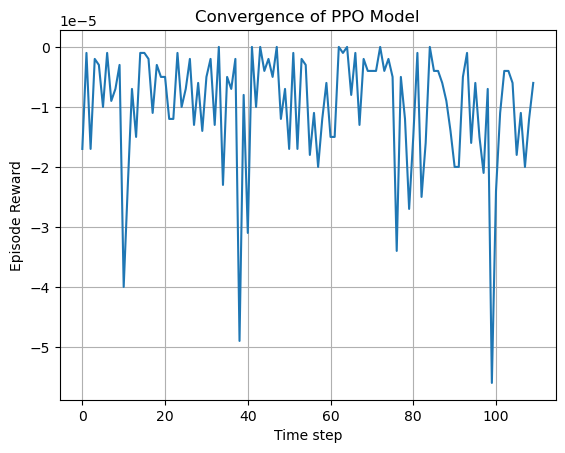

In [190]:
log_data = pd.read_csv(log_dir + "monitor.csv", skiprows=1)
window = 50
#smoothed_rewards = log_data["r"].rolling(window).mean()
smoothed_rewards = pd.Series(all_rewards[0][:-1]).rolling(window=10).mean()
#plt.ylim(-0.00002,0)
plt.plot(1)
plt.plot(smoothed_rewards)
plt.show()

plt.plot(log_data["r"])  # "l" (length) vs "r" (reward)
plt.xlabel("Time step")
plt.ylabel("Episode Reward")
plt.title("Convergence of PPO Model")
plt.grid()
plt.show()



### Run a test

In [164]:
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
num_eval_episodes = 1

episode_over = False
rewards = list()
actions = list()
pnl = list()
obs, info = env.reset()
while not episode_over:
    action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    pnl.append(info['P&L'])
    episode_over = terminated or truncated
# env.close()

print(f'Example action taken: {actions}')
print(f'Episode rewards: {rewards}')

Example action taken: [array([-1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1.,
       -1., -1., -1.,  1., -1.], dtype=float32), array([-1.        , -1.        ,  1.        ,  1.        ,  1.        ,
       -1.        ,  1.        , -1.        , -1.        ,  1.        ,
        1.        , -1.        ,  0.8294781 , -1.        , -1.        ,
       -0.7039385 ,  0.82507885,  1.        ], dtype=float32), array([ 0.11956573,  1.        ,  1.        ,  1.        ,  0.11612803,
       -0.2606727 , -1.        , -1.        ,  0.11062703, -0.28050792,
       -0.2604643 , -0.6538365 ,  1.        , -1.        , -1.        ,
       -1.        , -0.24504304, -1.        ], dtype=float32), array([ 1.        ,  0.693776  , -1.        ,  0.89663565,  0.5118697 ,
       -1.        ,  1.        , -1.        , -0.21390066,  1.        ,
       -1.        , -1.        ,  0.7533874 ,  1.        , -1.        ,
       -1.        ,  1.        ,  1.        ], dtype=float32), array([ 0.97513103,

In [17]:
num_eval_episodes = 10

rewards_tot = list()
actions_tot = list()
pnl_tot = list()
obs, info = env.reset()
for i in range(num_eval_episodes):
    episode_over = False
    rewards = list()
    actions = list()
    pnl = list()
    obs, info = env.reset()
    while not episode_over:
        action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        actions.append(action)
        pnl.append(info['P&L'])
        episode_over = terminated or truncated
    # env.close()
    rewards_tot.append(rewards)
    actions_tot.append(actions)
    pnl_tot.append(pnl)

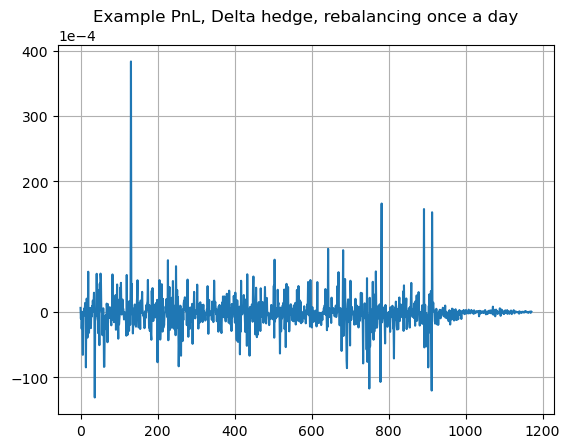

In [143]:
plt.figure(1)
plt.title("Example PnL, Delta hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(pnl_tot[9])

In [18]:
np.mean([np.percentile(i, 5) for i in pnl_tot])

np.float64(-0.0027407521662838152)

In [ ]:
def pnl_cva(path):
    pnl_without_hedge = np.zeros(len(path.CVA)-1)
    for i in range(1, len(path.CVA)):
        pnl_without_hedge[i-1] = path.CVA[i]-path.CVA[i-1]
    return pnl_without_hedge

pnl_without_hedge = [None]*len(paths)
for i in range(len(pnl_without_hedge)):
    pnl_without_hedge[i] = pnl_cva(paths[i])

plt.figure(2)
# Extract the 5% worst percentile values from each array
var_values_no_hedge = np.array([np.percentile(p,5) for p in pnl_without_hedge]) # is this really VaR?

var_values_no_hedge

## Try last year's

In [73]:
from stable_baselines3 import PPO

policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=dict(pi=[512,512], vf=[512,512]))

model = PPO("MlpPolicy", env, policy_kwargs = policy_kwargs, verbose=1)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [74]:
Nruns = 900
model.learn(total_timesteps=2520*Nruns, log_interval=20) # exploration_fraction=0.2
model.save("ppo_fin")

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.17e+03    |
|    ep_rew_mean          | -4.29e-06   |
| time/                   |             |
|    fps                  | 439         |
|    iterations           | 20          |
|    time_elapsed         | 93          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.009098293 |
|    clip_fraction        | 0.07        |
|    clip_range           | 0.2         |
|    entropy_loss         | -25         |
|    explained_variance   | 0.8801881   |
|    learning_rate        | 0.0003      |
|    loss                 | -0.017      |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00726    |
|    std                  | 0.973       |
|    value_loss           | 2.82e-05    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

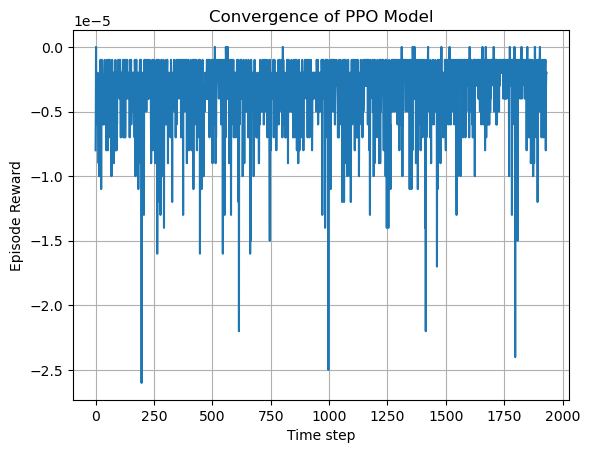

In [75]:
log_data = pd.read_csv(log_dir + "monitor.csv", skiprows=1)

# Plot the convergence curve
plt.plot(log_data["r"])  # "l" (length) vs "r" (reward)
plt.xlabel("Time step")
plt.ylabel("Episode Reward")
plt.title("Convergence of PPO Model")
plt.grid()
plt.show()